In [ ]:
# Checkout www.pygimli.org for more examples


# Polyfit

This tutorial shows a flexible inversion with an own forward calculation that
includes an own jacobian. We start with fitting a polynomial of degree
$P$

\begin{align}f(x) = p_0 + p_1 x + \ldots + p_P x^P = \sum\limits_{i=0}^{P} p_i x^i\end{align}

to given data $y$.
The unknown model is the coefficient vector ${\bf m}=[p_0,\ldots,p_P]$.
The vectorized function for a vector
${\bf x}=[x_1,\ldots,x_N]^T$
can be written as matrix-vector product

\begin{align}{\bf f} ({\bf x}) = {\bf A} {\bf x} \quad\mbox{with}\quad {\bf A}=
  \left[
    \begin{array}{cccc}
        1 & x_1    & \ldots & x_1^P \\
   \vdots & \vdots & \ddots & \vdots \\
        1 & x_N    & \ldots & x_N^P
  \end{array}
  \right] =
  [ {\bf 1}\quad {\bf x} \quad {\bf x}^2 \ldots {\bf x}^P ] \;.\end{align}

We set up the modelling operator, i.e. to return ${\bf f}({\bf x})$ for
given $p_i$, as a class derived from the modelling base class.
The latter holds the main mimic of generating Jacobian, gradients by brute
force. The only function to overwrite is \cw{response()}.

Python is a very flexible language for programming and scripting and has many
packages for numerical computing and graphical visualization.
For this reason, we built Python bindings and compiled the library pygimli.
As a main advantage, all classes can be used and derived.
This makes the use of GIMLi very easy for non-programmers.
All existing modelling classes can be used, but it is also easy to create new
modelling classes.

We exemplify this by the preceding example.

First, the library must be imported.

To avoid name clashes with other libraries we suggest to import `pygimli` and
alias it to an easy name (as usually done for numpy or matplotlib), e.g. by


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

The modelling class is derived from ModellingBase, a constructor is defined
and the response function is defined. Due to the linearity of the problem we
store the matrix ${\bf A}$, which is also the Jacobian matrix and use
it for the forward calculation. A second function is just added as reference.
We overwrite the method createJacobian as we know it but do nothing in the
actual computation. If ${\bf J}$ depends on ${\bf m}$ this
function must be filled.



In [2]:
class FunctionModelling(pg.Modelling):
    """Forward operator for polynomial interpolation."""

    def __init__(self, nc, xvec, verbose=False):
        super().__init__(verbose=verbose)
        self.x_ = xvec
        self.nc_ = nc
        nx = len(xvec)
        self.regionManager().setParameterCount(nc)
        self.jacobian().resize(nx, nc)
        for i in range(self.nc_):
            self.jacobian().setCol(i, pg.math.pow(self.x_, i))

    def response(self, model):
        """Return forward response by multiplying with kernel matrix."""
        return self.jacobian() * model

    def responseDirect(self, model):
        """Forward response step by step."""
        y = pg.Vector(len(self.x_), model[0])

        for i in range(1, self.nc_):
            y += pg.math.pow(self.x_, i) * model[i]

        return y

    def createJacobian(self, model):
        """Do nothing (avoid default brute-force Jacobian)."""
        pass  # if J depends on the model you should work here

    def createStartModel(self, data):
        """Create some starting model in the order of the data."""
        return pg.Vector(self.nc_, np.mean(data)/self.nc_/3)

Let us create some synthetic data for some x values



In [3]:
x = np.arange(0., 10., 0.5)
y = 1.1 + 2.1 * x - 0.2 * x**2
error = 0.5
np.random.seed(1337)  # make noise reproducible
noise = np.random.randn(len(y)) * error
y += noise

In [6]:
print(noise)

[-0.35159365 -0.24514118 -0.16090716 -0.87753936  0.10333224 -1.00563229
 -0.27862535  0.1686085   0.77441799 -0.68536828  0.7126457  -0.13973195
 -0.27981395  0.59319168  0.84925945 -0.84561008 -0.34976142  0.29148142
  0.48911131 -0.60868605]


Note the difference between error and noise. The error model is a scalar or
a vector containing the standard deviations of the noise, which is an unknown
realization of it. Errors are sometimes derived by stacking or estimated by
using a relative and an absolute error contribution.



We now start by setting up the modelling operator, and inversion and run it.



In [7]:
fop = FunctionModelling(3, x)
# initialize inversion with data and forward operator and set options
inv = pg.frameworks.MarquardtInversion(fop=fop)
# We set model transformation to linear to allow for negative values
# (by default model parameters are expected to be positive!)
inv.modelTrans = pg.trans.Trans()

the problem is well-posed and does not need any regularization (lam=0)
actual inversion run yielding coefficient model



In [8]:
coeff = inv.run(dataVals=y, absoluteError=noise, lam=0, verbose=True)

11/04/24 - 16:07:48 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.534187/0.534187
11/04/24 - 16:07:48 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.FunctionModelling object at 0x000001C4AA6B53A0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001C4AA6C4190>
Model transformation: <pgcore._pygimli_.RTrans object at 0x000001C4AA6B5AD0>
min/max (data): 0.75/7.31
min/max (error): 2.16%/46.98%
min/max (start model): 0.53/0.53
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 2954.75
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    0.95 (dPhi = 99.97%) lam: 0.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    0.95 (dPhi = -0.00%) lam: 0.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.95 (dPhi = 0.00%) lam: 0.0
################################################################################
#                 Abort criterion reached: dPhi = 0.0 (< 0.5%)                 #
###############

The data and model response are plotted by



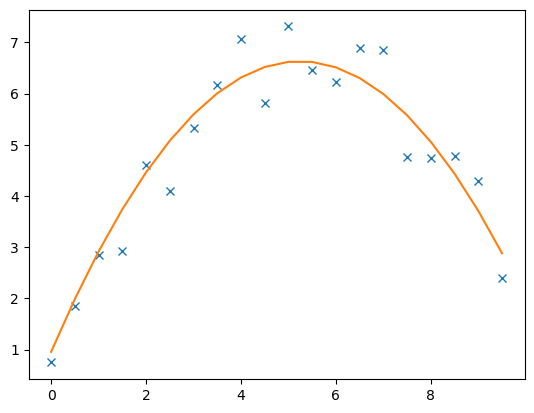

In [9]:
plt.plot(x, y, 'x', x, inv.response, '-')
plt.show()

The model contains the inverted coefficients



In [10]:
print(coeff)

3 [0.9560268156985832, 2.167015593973964, -0.2067697154645879]


Of course the model can also be fit by higher or lower polynomials



11/04/24 - 16:08:26 - pyGIMLi - INFO - Created startmodel from forward operator: 8, min/max=0.200320/0.200320
11/04/24 - 16:08:26 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.FunctionModelling object at 0x000001C4AA91A890>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001C4AA6C5AF0>
Model transformation: <pgcore._pygimli_.RTrans object at 0x000001C4AA697AB0>
min/max (data): 0.75/7.31
min/max (error): 6.84%/66.81%
min/max (start model): 0.2/0.2
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 903726955864.56
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 58130191.53 (dPhi = 99.99%) lam: 0.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   13.66 (dPhi = 100.00%) lam: 0.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.97 (dPhi = 92.87%) lam: 0.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    0.97 (dPhi = 0.49%) lam: 0.0
##############################

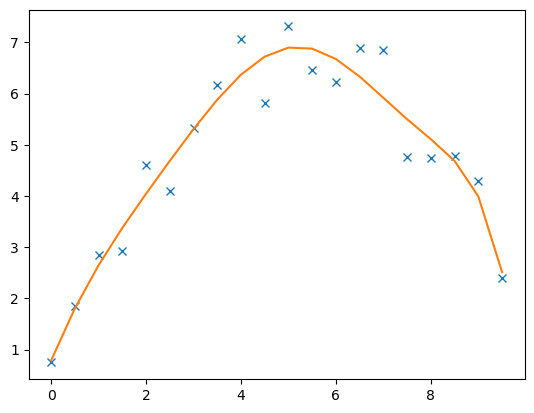

In [11]:
fop = FunctionModelling(8, x)
inv = pg.frameworks.MarquardtInversion(fop=fop)
inv.modelTrans = pg.trans.Trans()
coeff = inv.run(dataVals=y, absoluteError=error, lam=0, verbose=True)
print(coeff)
plt.plot(x, y, 'x', x, inv.response, '-')
plt.show()

Note that the function tries to fit the noise which is also expressed in a
chi-square value below 1, whereas the previous one was above 1. For small
data vectors it is hard to reach exactly 1 (data fitted within noise).
The chi-square value can be returned from the inversion object just like the
absolute and relative RMS (root-mean-square) misfits.



In [12]:
print(inv.chi2(), inv.absrms(), inv.relrms())

0.9693293439470893 0.49227262364138463 9.50253013960583


As there is often misunderstanding among the terms, we are giving some
background here. The root-mean-square of a vector is, as the name says, the
root of the mean squared elements (N being the length of the vector)

\begin{align}rms(v) = \sqrt{\frac{1}{N} \sum_i^N v_i^2}\end{align}

We consider the misfit between data vector d and the forward response f(m).
The simplest (absolute) measure is therefore called absolute RMS (ARMS):

\begin{align}ARMS = \sqrt{\frac{1}{N} \sum_i^N \left(d_i-f_i(m)\right)^2}\end{align}

which can also be computed by simple numpy functions



In [13]:
absmisfit = y - inv.response
print(np.sqrt(np.mean(absmisfit**2)))

0.49227262364138463


In case of a large magnitude range (e.g. TEM voltages) one uses a logarithmic
view (and axis) to look at the data values. Often the relative errors
(absolute log errors) make more sense. For the relative RMS, the misfit
values are divided by the data points itself:

\begin{align}RRMS = \sqrt{\frac{1}{N} \sum_i^N \left(\frac{d_i-f_i(m)}{d_i}\right)^2}\end{align}



In [14]:
relmisfit = (y - inv.response) / y
print(np.sqrt(np.mean(relmisfit**2))*100)  # in %
logmisfit = np.log(y) - np.log(inv.response)
print(np.sqrt(np.mean(logmisfit**2))*100)

9.50253013960583
9.329510387864607


So the absolut logarithmic misfit is close to the relative misfit.
In inversion, neither of the quantities is minimized. Instead, we use the
error to compute an error-weighted misfit (ERMS), sometimes also referred to
as inversion RMS (to recognize since it is without data unit or %).

\begin{align}ERMS = \sqrt{\frac{1}{N} \sum_i^N \left(\frac{d_i-f_i(m)}{e_i}\right)^2}\end{align}

It represents the standard deviation of the error-weighted misfit.



In [15]:
weighted_misfit = (y - inv.response) / error
print(np.sqrt(np.mean((weighted_misfit**2))))

0.9845452472827693


For historical statistical reasons, instead of the standard deviation the
variance is used and referred to as chi square.

\begin{align}\chi^2 = \frac{1}{N} \sum_i^N \left(\frac{d_i-f_i(m)}{e_i}\right)^2
           = \Phi_d / N\end{align}

whereas $\Phi_d$ is the data objective function minimized in inversion.



In [16]:
print(np.mean((weighted_misfit**2)))

0.9693293439470893


The whole history of the chi-square fit can be looked at by



In [17]:
print(inv.chi2History)

[903726955864.5553, 58130191.5321299, 13.664081248774073, 0.9740662574947402, 0.9693293439470893]
